# A first look at data

date: 12/04/2018

Example code for reading and checking data


In [1]:
import pandas as pd
import dask.dataframe as dd
import glob as glob
import numpy as np
from scipy.stats import kde

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import LogNorm
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

This is the part that reads data and makes a basic selection

In [2]:
df = pd.DataFrame()
df = pd.read_hdf('/data/IceCube/merged2015.h5', key='data')
df['cos2'] = np.cos(df.zenith)**2
df['I'] = 0
df['s125_error'] = 0.1*df['s125']

df.drop(df.columns.difference(['s125', 's125_error',"cos2", "I","zenith"]), 1, inplace= True)
df= df.loc[df.s125>25]
df= df.loc[df.cos2>0.5]  
df.reset_index(inplace=True)
print('You have selected {} events'.format(df.s125.count()))



You have selected 37382 events


In [3]:
import os
filepath='/home/ioana/src/icecube/Noemi/stage/cic_att' 
os.chdir(filepath)
%run data_functions.py
from data_functions import obtain_attenuation
n_bins = 10
intensity = 200
samples = 100

fit_results, fitted_data = obtain_attenuation(df, n_bins, intensity, samples )

  0%|          | 0/100 [00:00<?, ?it/s]/data/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


a = 0.431196 + 0.035856 - 0.036396

b = -2.976437 + 0.168285 - 0.150001

s_ref = 141.340133 + 0.528890 - 0.599291



<Container object of 3 artists>

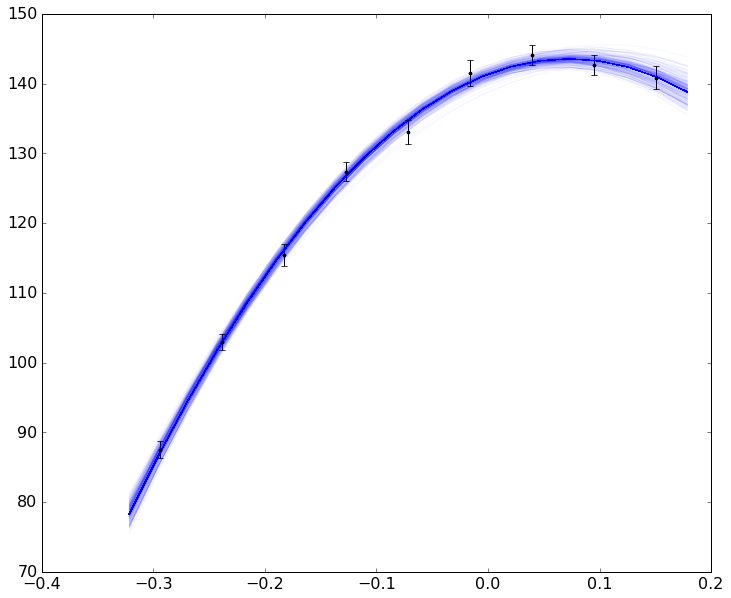

In [5]:
import math
groups = fitted_data
sample = fit_results
cos_ref = np.cos(math.radians(25))**2
cos2 = np.linspace(0.5, 1, 20)-cos_ref

a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                  zip(*np.percentile(sample, [16, 50, 84],
                                      axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s_ref = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))

# Plot a subset of the samples
plt.errorbar(groups.cos2.mean()-cos_ref, groups.s125.mean(), yerr= groups.s125.std().tolist(), fmt=".k")
for a, b, f in sample[np.random.randint(len(sample), size=250)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="b", alpha=0.03)
    plt.plot(cos2, s38_mcmc[0] * (b_mcmc[0] * cos2**2 + a_mcmc[0] * cos2 + 1), color="b", lw=0.5, alpha=0.8)
plt.errorbar(groups.cos2.mean()-cos_ref, groups.s125.mean(), yerr= groups.s125.std().tolist(), fmt=".k")

a = 0.431196 + 0.035856 - 0.036396

b = -2.976437 + 0.168285 - 0.150001

s38 = 141.340133 + 0.528890 - 0.599291



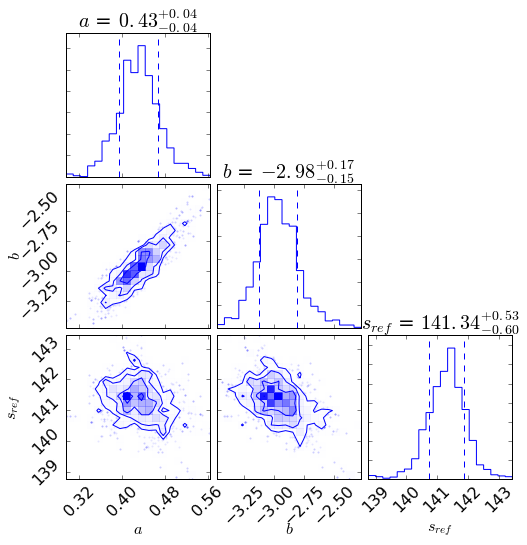

In [6]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s_{ref}$"], quantiles=[0.16, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 20}, color='b')
#fig.savefig("")
a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(sample, [16, 50, 84],
                                                axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s38 = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))

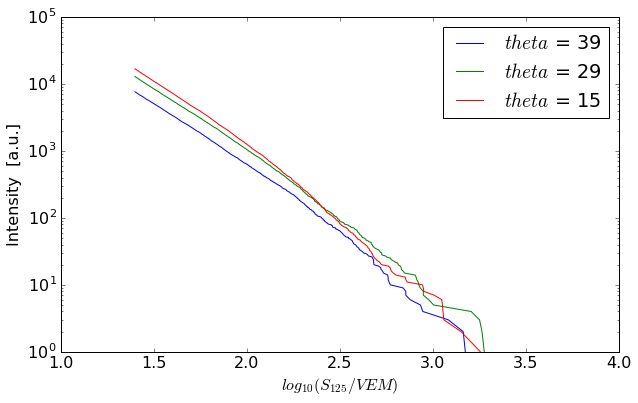

In [7]:
fig2, ax2 =plt.subplots(figsize=(10,6))
temp, groups = set_intensity(df, 4)
for name, group in groups:
    ax2.plot(np.log10(group.s125), group.I, 
             label='$theta$ = {}'.format(math.floor(math.degrees(group.zenith.mean()))))
ax2.set_yscale("log", nonposy='clip')
plt.xlabel("$log_{10}(S_{125}/VEM)$")
plt.ylabel("Intensity  [a.u.]")

plt.legend()


  

In [12]:
%run data_functions.py
from data_functions import set_intensity
df['s38'] = df.s125/(b_mcmc[0] * (df.cos2-cos_ref)**2 + a_mcmc[0] * (df.cos2-cos_ref) + 1)

print(df)
temp, groups = set_intensity(df, 4, 's38')
for name, group in groups:
    ax2.plot(np.log10(group.s125), group.I, 
             label='$theta$ = {}'.format(math.floor(math.degrees(group.zenith.mean()))))
ax2.set_yscale("log", nonposy='clip')
plt.xlabel("$log_{10}(S_{125}/VEM)$")
plt.ylabel("Intensity  [a.u.]")

plt.legend()

        index    zenith         s125      cos2      I  s125_error          s38
35911   65036  0.586748  3934.734870  0.693465      0  393.473487  4390.828172
23393  163388  0.292632  2137.845257  0.916783      0  213.784526  2108.227661
3558    43818  0.516215  1887.842352  0.756367      1  188.784235  1967.783593
26139   42425  0.440893  1836.233885  0.817886      2  183.623389  1839.082543
10741   71305  0.257697  1799.580456  0.935049      1  179.958046  1780.776321
35314  143098  0.471971  1781.369933  0.793300      3  178.136993  1807.512592
22523  138538  0.534751  1604.815714  0.740280      4  160.481571  1697.425580
15637  124799  0.749164  1519.002138  0.536203      0  151.900214  2392.352480
6673    90954  0.761682  1493.571141  0.523708      1  149.357114  2457.033737
7827   158617  0.679031  1454.972676  0.605566      2  145.497268  1893.783353
5434    23634  0.216722  1417.025668  0.953762      2  141.702567  1410.080466
4178    92111  0.665296  1210.213711  0.618950      

TypeError: set_intensity() takes 2 positional arguments but 3 were given